<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: *Elias CHERIF*
### ***username***: *gems-ec2823*
### ***CID***: *02522867*


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## Hyperparameter tunning notebook

Explain the steps and tests you do.

Organise it well to show how the data you present here has helped you design your final network hyperparameters (that you will use for the final training in the `yourusername_DLcw1_clean.ipynb` notebook).

add text blocks as you need

In [1]:
!pip install pycm livelossplot
%pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 15.1 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


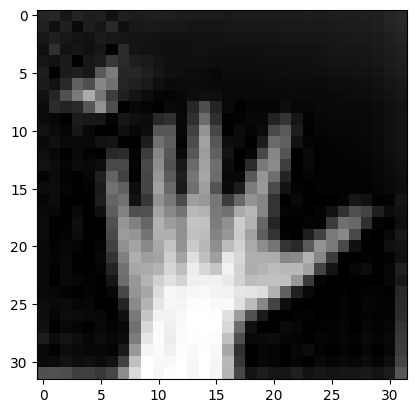

Nombre de lots = 63
Nombre d'images = 8010


In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.images = os.listdir(images_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

chemin_images = '/content/drive/My Drive/real_hands'

transformations = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])
])

batch_size = 128
dataset = CustomImageDataset(images_dir=chemin_images, transform=transformations)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

images = next(iter(data_loader))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.show()

print('Nombre de lots = ' + str(len(data_loader)))
print('Nombre d\'images = ' + str(len(dataset)))

In [5]:
images = images.float()

min_val = images.min().item()
max_val = images.max().item()
mean_val = images.mean().item()
std_val = images.std().item()

print("min/max:", min_val, "/", max_val)
print("mean: ", mean_val)
print("std: ", std_val)

min/max: -1.0 / 1.0
mean:  -0.4831969738006592
std:  0.6114926934242249


We're going to try out a VAE to see its potential

In [7]:
class VAE_Encoder(nn.Module):
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''

    super(VAE_Encoder, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(32*32, 512),
        nn.ReLU()
    )
    self.layer2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU()
    )
    self.layerMu = nn.Sequential(
        nn.Linear(128, 10),

    )

    self.layerSigma = nn.Sequential(
        nn.Linear(128, 10),

    )

  def forward(self, x):  # Custom pytorch modules should follow this structure
    '''
    x: [float] the MNIST image
    '''

    x = torch.flatten(x, start_dim = 1)  # Reshape the input into a vector (nD to 1D)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    mu =  self.layerMu(x)
    sigma = torch.exp(self.layerSigma(x))
    return mu, sigma

In [8]:
encoder = VAE_Encoder()

images = next(iter(data_loader))  # Get the first batch of images
print(images[0].shape)  # Get the first image from the batch
mu, sigma = encoder(images[0].unsqueeze(0))  # Are mu and sigma correct

print(mu.detach())
print(sigma.detach())

torch.Size([1, 32, 32])
tensor([[ 0.0757,  0.0072,  0.0129, -0.0911,  0.0210,  0.0178, -0.0784, -0.1488,
         -0.0099,  0.1302]])
tensor([[1.0070, 1.0144, 0.9639, 1.0287, 1.0099, 0.9945, 1.0059, 1.0837, 1.0281,
         1.0361]])


In [11]:
class VAE_Decoder(nn.Module):
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(VAE_Decoder, self).__init__()

    self.layerLatent = nn.Sequential(
        nn.Linear(10, 128),

    )

    self.layer1 = nn.Sequential(
        nn.Linear(128, 256),
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(512, 32*32),
        nn.Sigmoid()
    )

  def forward(self, z):
    '''
    x: [float] the MNIST image
    '''

    z = self.layerLatent(z)
    z = self.layer1(z)
    z = self.layer2(z)
    z = self.layer3(z)
    return z.reshape((-1,1,32,32))

In [13]:
class VAE(nn.Module):
  def __init__(self, device):
    '''
    Class combines the Encoder and the Decoder with a VAE latent space.
    '''
    super(VAE, self).__init__()
    self.device = device
    self.encoder = VAE_Encoder()
    self.decoder = VAE_Decoder()
    self.distribution = torch.distributions.Normal(0, 1)

  def sample_latent_space(self, mu, sigma):
    z = mu + sigma * self.distribution.sample(mu.shape).to(self.device)
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z, kl_div

  def forward(self, x):
    '''
    x - [float] A batch of images from the data-loader
    '''

    mu, sigma = self.encoder(x)
    z, kl_div = self.sample_latent_space(mu, sigma)
    z = self.decoder(z)
    return z, kl_div

torch.Size([1, 32, 32])


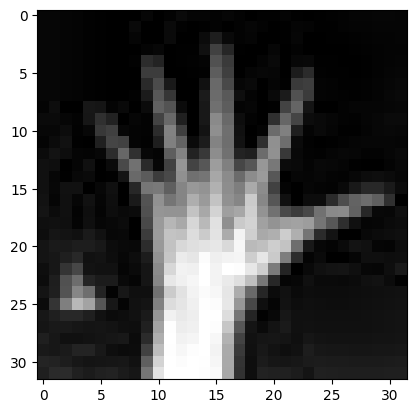

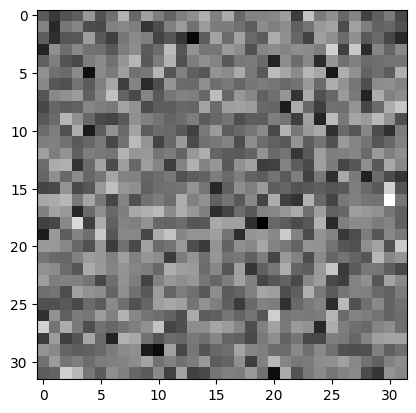

In [14]:
vae = VAE('cpu')

images = next(iter(data_loader))  # Get the first batch of images
print(images[0].shape)  # Get the first image from the batch
recon, _ = vae(images[10].unsqueeze(0))  # Are mu and sigma correct

plt.figure(); plt.imshow(images[0].squeeze(), 'gray')
plt.figure(); plt.imshow(recon.cpu().detach().squeeze(), 'gray')

In [19]:
from tqdm import tqdm
import torch

def train(autoencoder, data, kl_div_on=True, epochs=10, device='cpu'):
    opt = torch.optim.Adam(autoencoder.parameters())
    loss_history = []

    for epoch in range(epochs):  # Run data over numerous epochs
        total_loss = 0
        for batch in tqdm(data):  # Iterate over the batches of images and labels
            batch = batch.to(device)  # Send batch of images to the GPU
            opt.zero_grad()  # Set optimiser grad to 0
            x_hat, KL = autoencoder(batch)  # Generate predicted images (x_hat) by running batch of images through autoencoder
            loss = ((batch - x_hat)**2).sum() + KL  # Calculate combined loss
            loss.backward()  # Back-propagate
            opt.step()  # Step the optimiser
            total_loss += loss.item()

        average_loss = total_loss / len(data)
        loss_history.append(average_loss)
        print(f'Epoch {epoch+1}, Loss: {average_loss}')

    return autoencoder, loss_history  # Return the trained autoencoder and the loss history
device = 'cuda'

dims_latent = 2
vae = VAE(device).to(device)
vae, loss_history  = train(vae, data_loader, epochs=50, device=device)

print('done')



100%|██████████| 63/63 [00:12<00:00,  5.15it/s]


Epoch 1, Loss: 83589.75452628969


100%|██████████| 63/63 [00:15<00:00,  4.08it/s]


Epoch 2, Loss: 72369.75161210318


100%|██████████| 63/63 [00:13<00:00,  4.69it/s]


Epoch 3, Loss: 71351.05481150794


100%|██████████| 63/63 [00:12<00:00,  4.87it/s]


Epoch 4, Loss: 70775.36005704365


100%|██████████| 63/63 [00:12<00:00,  5.12it/s]


Epoch 5, Loss: 70499.78391617064


100%|██████████| 63/63 [00:12<00:00,  5.11it/s]


Epoch 6, Loss: 70316.22526041667


100%|██████████| 63/63 [00:12<00:00,  5.19it/s]


Epoch 7, Loss: 70113.79191468254


100%|██████████| 63/63 [00:12<00:00,  5.16it/s]


Epoch 8, Loss: 69971.66958085318


100%|██████████| 63/63 [00:12<00:00,  5.07it/s]


Epoch 9, Loss: 69832.56312003969


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


Epoch 10, Loss: 69772.32564484127


100%|██████████| 63/63 [00:12<00:00,  5.09it/s]


Epoch 11, Loss: 69706.96577380953


100%|██████████| 63/63 [00:12<00:00,  5.14it/s]


Epoch 12, Loss: 69650.47910466269


100%|██████████| 63/63 [00:11<00:00,  5.26it/s]


Epoch 13, Loss: 69610.69698660714


100%|██████████| 63/63 [00:13<00:00,  4.77it/s]


Epoch 14, Loss: 69577.96831597222


100%|██████████| 63/63 [00:12<00:00,  5.22it/s]


Epoch 15, Loss: 69549.43644593254


100%|██████████| 63/63 [00:12<00:00,  5.05it/s]


Epoch 16, Loss: 69527.93074156746


100%|██████████| 63/63 [00:12<00:00,  5.04it/s]


Epoch 17, Loss: 69504.01977926587


100%|██████████| 63/63 [00:12<00:00,  5.22it/s]


Epoch 18, Loss: 69479.44159226191


100%|██████████| 63/63 [00:12<00:00,  5.15it/s]


Epoch 19, Loss: 69447.82806299604


100%|██████████| 63/63 [00:11<00:00,  5.34it/s]


Epoch 20, Loss: 69449.68601190476


100%|██████████| 63/63 [00:12<00:00,  5.21it/s]


Epoch 21, Loss: 69449.34939236111


100%|██████████| 63/63 [00:12<00:00,  5.18it/s]


Epoch 22, Loss: 69424.70969742064


100%|██████████| 63/63 [00:12<00:00,  5.19it/s]


Epoch 23, Loss: 69409.36700148809


100%|██████████| 63/63 [00:12<00:00,  5.20it/s]


Epoch 24, Loss: 69397.75440228175


100%|██████████| 63/63 [00:12<00:00,  5.22it/s]


Epoch 25, Loss: 69378.59821428571


100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


Epoch 26, Loss: 69360.08072916667


100%|██████████| 63/63 [00:12<00:00,  5.19it/s]


Epoch 27, Loss: 69355.04861111111


100%|██████████| 63/63 [00:12<00:00,  5.13it/s]


Epoch 28, Loss: 69343.87307787698


100%|██████████| 63/63 [00:12<00:00,  5.15it/s]


Epoch 29, Loss: 69336.79408482143


100%|██████████| 63/63 [00:12<00:00,  5.15it/s]


Epoch 30, Loss: 69339.64446924604


100%|██████████| 63/63 [00:11<00:00,  5.27it/s]


Epoch 31, Loss: 69315.55158730158


100%|██████████| 63/63 [00:12<00:00,  5.17it/s]


Epoch 32, Loss: 69315.23976934524


100%|██████████| 63/63 [00:12<00:00,  5.23it/s]


Epoch 33, Loss: 69299.28056795635


100%|██████████| 63/63 [00:12<00:00,  5.25it/s]


Epoch 34, Loss: 69305.29495287698


100%|██████████| 63/63 [00:12<00:00,  5.20it/s]


Epoch 35, Loss: 69277.60794890873


100%|██████████| 63/63 [00:11<00:00,  5.27it/s]


Epoch 36, Loss: 69278.95498511905


100%|██████████| 63/63 [00:11<00:00,  5.25it/s]


Epoch 37, Loss: 69274.36049107143


100%|██████████| 63/63 [00:12<00:00,  5.17it/s]


Epoch 38, Loss: 69272.6546999008


100%|██████████| 63/63 [00:12<00:00,  5.22it/s]


Epoch 39, Loss: 69252.65587797618


100%|██████████| 63/63 [00:12<00:00,  5.25it/s]


Epoch 40, Loss: 69254.70411706349


100%|██████████| 63/63 [00:12<00:00,  5.21it/s]


Epoch 41, Loss: 69232.21670386905


100%|██████████| 63/63 [00:12<00:00,  5.21it/s]


Epoch 42, Loss: 69233.25917658731


100%|██████████| 63/63 [00:12<00:00,  5.16it/s]


Epoch 43, Loss: 69237.50241815476


100%|██████████| 63/63 [00:12<00:00,  5.17it/s]


Epoch 44, Loss: 69241.49094742064


100%|██████████| 63/63 [00:12<00:00,  5.18it/s]


Epoch 45, Loss: 69233.04086061507


100%|██████████| 63/63 [00:11<00:00,  5.27it/s]


Epoch 46, Loss: 69216.47135416667


100%|██████████| 63/63 [00:11<00:00,  5.29it/s]


Epoch 47, Loss: 69214.48536706349


100%|██████████| 63/63 [00:11<00:00,  5.26it/s]


Epoch 48, Loss: 69211.82043650794


100%|██████████| 63/63 [00:12<00:00,  5.24it/s]


Epoch 49, Loss: 69203.53596230158


100%|██████████| 63/63 [00:12<00:00,  5.18it/s]

Epoch 50, Loss: 69193.84964037698
done


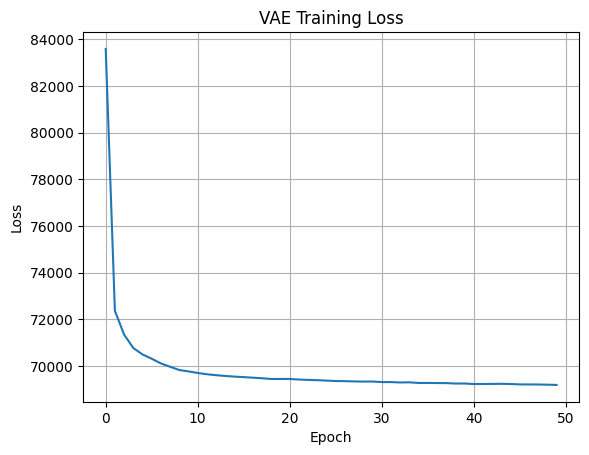

In [21]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

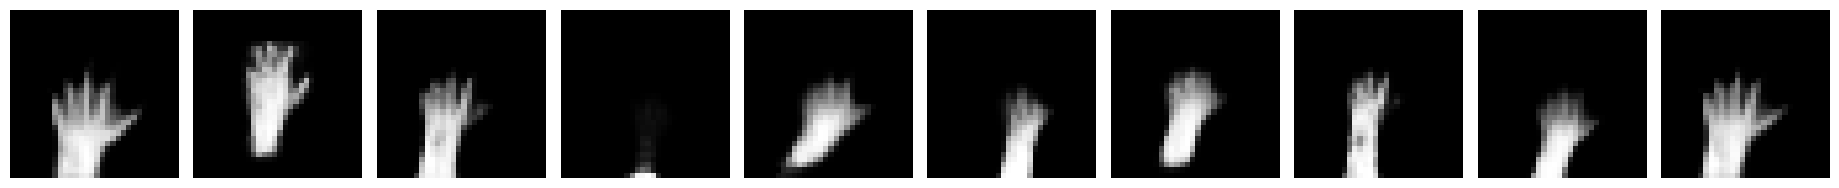

In [22]:
def generate_images(model, num_images):
    with torch.no_grad():
        z = torch.randn(num_images, 10).to(device)
        generated_images = model.decoder(z)

        return generated_images

num_images = 10
generated_images = generate_images(vae, num_images)

generated_images = generated_images.view(num_images, 1, 32, 32)
generated_images = generated_images.squeeze().cpu()

fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(18.5, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].numpy(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

Even though we used a very basic VAE model, we notice that it struggles to generate images that are faithful to reality. That's why we will continue with GANs.

---------------------------------------------------------------------------
----------------CONV-------------------


In [23]:
custom_image_path = None
batch_size = 128

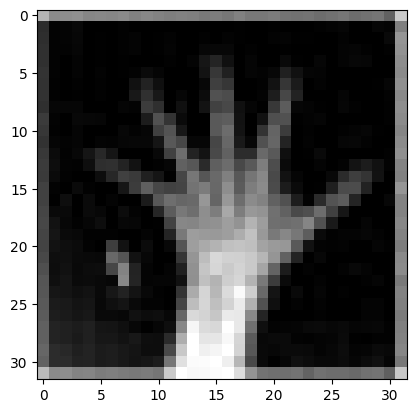

In [24]:
images = next(iter(data_loader))
plt.imshow(images[0].squeeze(), 'gray')
plt.show()

In [25]:
images.shape

torch.Size([128, 1, 32, 32])

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [78]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.init_size = 8 #Initial size before upscaling

        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        #Layer to start the convolution
        self.start_conv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        #upsampling with ConvTranspose2d
        self.conv_block1 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )


        self.conv_block2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )

        #output
        self.out_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  #values are between -1 and 1
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        out = self.start_conv(out)
        out = self.conv_block1(out)
        out = self.conv_block2(out)
        img = self.out_conv(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #input layer
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.lrelu1 = nn.LeakyReLU(0.2, inplace=True)

        #hidden layer 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.lrelu2 = nn.LeakyReLU(0.2, inplace=True)
        self.drop2 = nn.Dropout2d(0.1)
        self.bn2 = nn.BatchNorm2d(32)

        #hidden layer 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.lrelu3 = nn.LeakyReLU(0.2, inplace=True)
        self.drop3 = nn.Dropout2d(0.1)
        self.bn3 = nn.BatchNorm2d(64)

        # Hidden layer 3
        self.conv4 = nn.Conv2d(64, 128, 3, 2, 1)
        self.lrelu4 = nn.LeakyReLU(0.2, inplace=True)
        self.drop4 = nn.Dropout2d(0.1)
        self.bn4 = nn.BatchNorm2d(128)

        #final
        self.val_layer = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.lrelu1(self.conv1(img))
        out = self.bn2(self.drop2(self.lrelu2(self.conv2(out))))
        out = self.bn3(self.drop3(self.lrelu3(self.conv3(out))))
        out = self.bn4(self.drop4(self.lrelu4(self.conv4(out))))
        out = out.view(out.shape[0], -1)
        validity = self.val_layer(out)

        return validity

G = Generator().to(device)
D = Discriminator().to(device)

In [72]:
D

Discriminator(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lrelu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lrelu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (drop2): Dropout2d(p=0.1, inplace=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lrelu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (drop3): Dropout2d(p=0.1, inplace=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lrelu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (drop4): Dropout2d(p=0.1, inplace=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (val_layer): Sequential(
    (0): Linear(in_features=5

In [73]:
def D_train(x):
    #-------------- Function of the discriminator training -------------------#
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    current_bs = x.size(0) #taking into account differences in size
    x_real, y_real = x.view(-1,1, 32,32), torch.ones(current_bs, 1)  # we are assigning the label 'real data' to the samples (don't care anymore about what number they are)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(current_bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(current_bs, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [74]:
def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimizer.zero_grad()
    current_bs = x.size(0) #taking into account differences in size
    # sample vector and produce generator output
    z = torch.randn(current_bs, z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator

    y = torch.ones(current_bs, 1).to(device)
    G_loss = criterion(D_output, y)

    # model update
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

In [57]:
criterion = nn.BCELoss()
z_dim = 100
bs = 128  ## batch_size

lr = 0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

We increase the learning rate to see the effect on our model

In [58]:
G = Generator().to(device)
D = Discriminator().to(device)

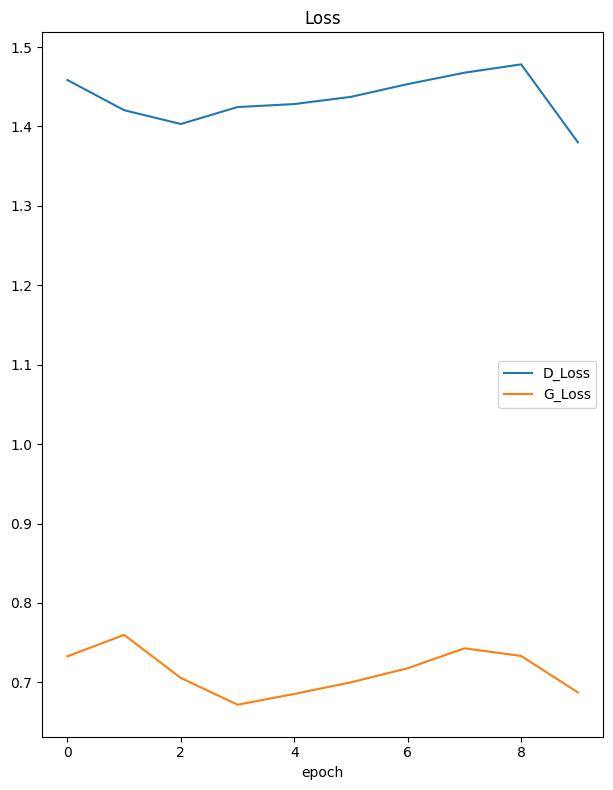

Loss
	D_Loss           	 (min:    1.380, max:    1.478, cur:    1.380)
	G_Loss           	 (min:    0.672, max:    0.760, cur:    0.687)


In [59]:
n_epoch = 10
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, x in enumerate(data_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

We can see that our discriminator outweighs our generator, which is not good for our model.

We're going to try and reduce our learning rate now

In [60]:
criterion = nn.BCELoss()
z_dim = 100
bs = 128  ## batch_size

lr = 0.00005
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [61]:
G = Generator().to(device)
D = Discriminator().to(device)

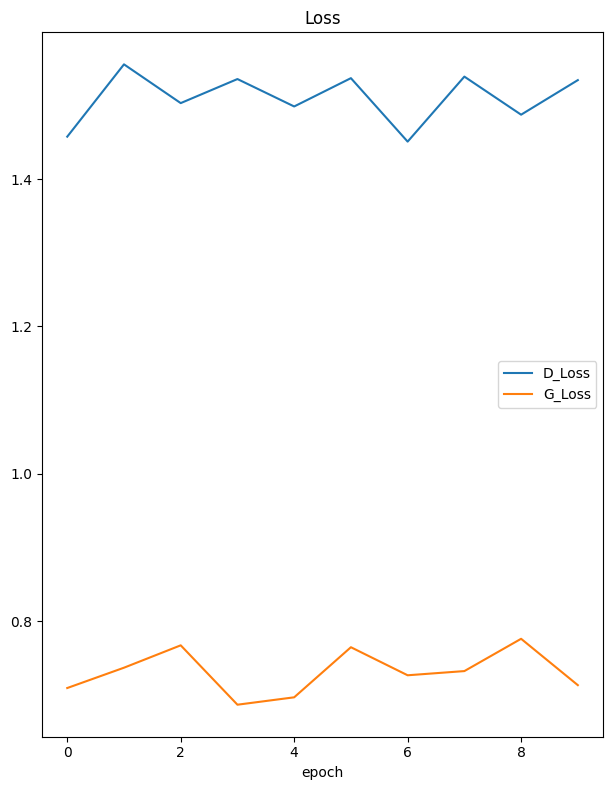

Loss
	D_Loss           	 (min:    1.451, max:    1.556, cur:    1.534)
	G_Loss           	 (min:    0.687, max:    0.776, cur:    0.713)


In [62]:
n_epoch = 10
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, x in enumerate(data_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

We can make the same observation as before

**We will therefore keep the following parameters:**

In [82]:
# define loss
criterion = nn.BCELoss()
z_dim = 100
bs = 128  # batch_size

lr = 0.0001

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

**We then try to find the best combination of Dropout2d, BatchNorm2d, LeakyReLU, etc. to give us the best results. **



In [83]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.init_size = 8 #Initial size before upscaling

        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        #Layer to start the convolution
        self.start_conv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        #upsampling with ConvTranspose2d
        self.conv_block1 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )


        self.conv_block2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )

        #output
        self.out_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  #values are between -1 and 1
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        out = self.start_conv(out)
        out = self.conv_block1(out)
        out = self.conv_block2(out)
        img = self.out_conv(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #input layer
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.lrelu1 = nn.LeakyReLU(0.2, inplace=True)

        #hidden layer 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.lrelu2 = nn.LeakyReLU(0.2, inplace=True)
        self.drop2 = nn.Dropout2d(0.1)
        self.bn2 = nn.BatchNorm2d(32)

        #hidden layer 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.lrelu3 = nn.LeakyReLU(0.2, inplace=True)
        self.drop3 = nn.Dropout2d(0.1)
        self.bn3 = nn.BatchNorm2d(64)

        # Hidden layer 3
        self.conv4 = nn.Conv2d(64, 128, 3, 2, 1)
        self.lrelu4 = nn.LeakyReLU(0.2, inplace=True)
        self.drop4 = nn.Dropout2d(0.1)
        self.bn4 = nn.BatchNorm2d(128)

        #final
        self.val_layer = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.lrelu1(self.conv1(img))
        out = self.bn2(self.drop2(self.lrelu2(self.conv2(out))))
        out = self.bn3(self.drop3(self.lrelu3(self.conv3(out))))
        out = self.bn4(self.drop4(self.lrelu4(self.conv4(out))))
        out = out.view(out.shape[0], -1)
        validity = self.val_layer(out)

        return validity


G = Generator().to(device)
D = Discriminator().to(device)

In [84]:
def D_train(x):
    #-------------- Function of the discriminator training -------------------#
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    current_bs = x.size(0) #taking into account differences in size
    x_real, y_real = x.view(-1,1, 32,32), torch.ones(current_bs, 1)  # we are assigning the label 'real data' to the samples (don't care anymore about what number they are)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(current_bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(current_bs, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [85]:
def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimizer.zero_grad()
    current_bs = x.size(0) #taking into account differences in size
    # sample vector and produce generator output
    z = torch.randn(current_bs, z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator

    y = torch.ones(current_bs, 1).to(device)
    G_loss = criterion(D_output, y)

    # model update
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

In [86]:
# define loss
criterion = nn.BCELoss()
z_dim = 100
bs = 128  # batch_size

lr = 0.0001

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

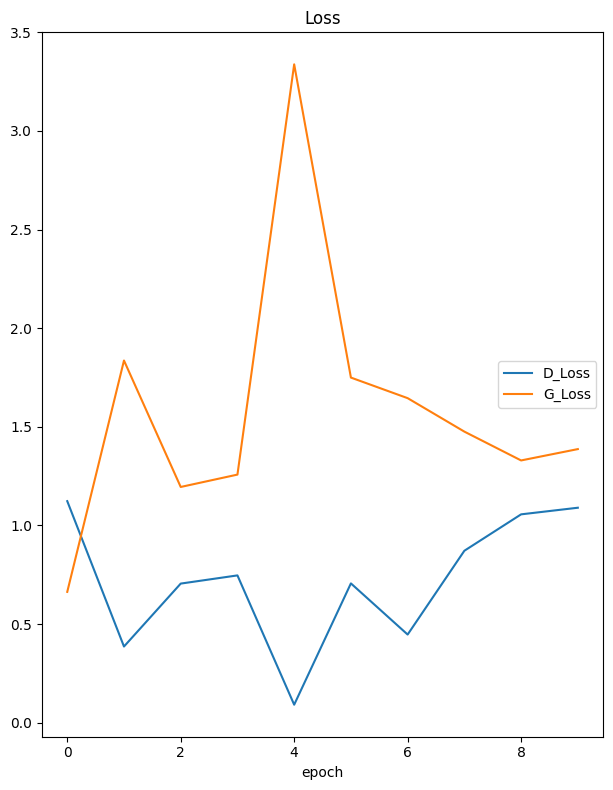

Loss
	D_Loss           	 (min:    0.091, max:    1.123, cur:    1.090)
	G_Loss           	 (min:    0.663, max:    3.338, cur:    1.387)


In [87]:
n_epoch = 10
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, x in enumerate(data_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

**We're keeping this model because it seems to be converging (the architecture is explained in the main notebook).**